In [92]:
from cmdstanpy import CmdStanModel
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

dp_mix_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // truncation of stick breaking construction dp
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> alpha;
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
    // betas for the mixture of the dirichlet process
    matrix[P+1,H]              betas; 
    
    // for the construction of the dirichlet process
    vector<lower=0,upper=1>[H-1] vs;
}

transformed parameters
{   // weights stick breaking construction
    simplex[H] omegas; 
    
    // sbc stuff
    vector<lower=0, upper=1>[H-1] cumprod_one_mv;    
    cumprod_one_mv = exp(cumulative_sum(log1m(vs)));
    
    omegas[1] = vs[1];
    omegas[2:(H-1)] = vs[2:(H-1)] .* cumprod_one_mv[1:(H-2)];
    omegas[H] = cumprod_one_mv[H-1];
    
    vector<lower=-1,upper=1>[I] xis;
    xis = 2 * xis_constructors - 1;

}

model
{
    alpha  ~ gamma(a_alpha,b_alpha);
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    vs     ~ beta(1,alpha);
    
    xis_constructors ~ beta(a_xi,b_xi);
     
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(i in 1:I)
    {
        for (h in 1:H)
            betas[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
        
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
            target += log_sum_exp(log_probs[i]);
    }
}

generated quantities 
{   
    // vector of cluster allocations
    vector[I] s;
    
    //matrix[I,I] inv_Q;
    //inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    matrix[I,H] log_probs;
    for (i in 1:I) 
    {
        for (h in 1:H) 
            log_probs[i,h] = log(omegas[h]) + multi_normal_lpdf(y[T*(i-1)+1:i*T] | X[T*(i-1)+1:i*T, 1:P+1]*betas[1:P+1,h]  + ws[1:T,i]  , sigma2*eye_T);
    
    }
    for (i in 1:I)
        s[i] = categorical_rng(softmax(log_probs[i,1:H]'));

    
}
"""

stan_file = "bayesian.stan"

with open(stan_file, "w") as fp:
    fp.write(dp_mix_stan)
    
dp_mix = CmdStanModel(stan_file=stan_file)

10:33:39 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/bayesian.stan to exe file /home/anna-ubuntu/bayesian-project/bayesian
10:35:43 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/bayesian


[[1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.

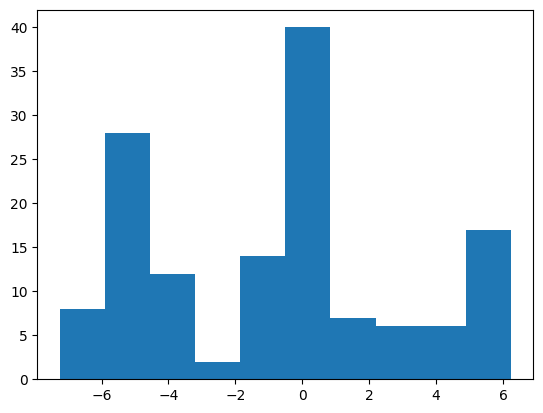

In [93]:
I = 20
T = 7
P = 3
H = 10
means = np.array([-5,0,5]) #vector of possible mean 
y = np.zeros(I*T)
true_clus_allocs = np.zeros(I) #cluster of each areal location 
for i in range(1,I+1): #for each areal location 
    true_clus = np.random.choice(np.arange(3), size=1) #choose a cluster randomly between (1,2,3)
    true_clus_allocs[i-1] = true_clus #save the cluster choosen
    y[T*(i-1):T*i] = np.random.normal(loc=means[true_clus],size= T) #sample for all the time from the cluster choosen
    # this are the data related to areal i for all time until T
plt.hist(y)

X = np.ones((I*T,P+1)) # in this way the first column is made by one
for i in range(I*T):
   X[i,1:] = np.random.normal(loc=1,size= P) #the other P covariates are choosen randomly


mu_0 = np.zeros(P+1) #as in the paper
mu_w_1 = np.zeros(I) #as in the paper

W_raw = np.eye(I) #proximity matrix, ones in the diagonal, symm, just made by 1 or 0
for i in range(I):
    for j in range(i):
        W_raw[i,j] = np.random.binomial(size=1, n=1, p= 0.5) #choosen rand from a bernoulli
        W_raw[j,i] = W_raw[i,j] #it has to be symm
print(W_raw)

Sigma_0 = np.eye(P+1) #covariance matrix


data = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1
}


In [94]:
true_clus_allocs

array([0., 1., 1., 2., 1., 1., 1., 0., 0., 0., 1., 1., 0., 2., 2., 0., 1.,
       2., 1., 0.])

In [95]:
fit = dp_mix.sample(data
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

10:37:58 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                        | 00:00 Status
chain 2 |                                                        | 00:00 Status

chain 3 |                                                        | 00:00 Status


chain 4 |                                                        | 00:00 Status
chain 2 |██▌                                                     | 00:00 Status


chain 4 |██▌                                                     | 00:00 Status

chain 1 |██▌                                                     | 00:00 Status


chain 4 |██                     | 01:21 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |██                     | 01:37 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 3 |██                     | 01:56 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |███▏                   | 02:09 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |███▏                   | 02:29 Iteration:  10


10:48:49 - cmdstanpy - INFO - CmdStan done processing.
10:48:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,3] = 9.26294e+44, but Covariance matrix[3,1] = 9.26294e+44 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,3] = 3.09678e+44, but Covariance matrix[3,1] = 3.09678e+44 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = 1.83042e+15, but Covariance matrix[2,1] = 1.83042e+15 (in '/home/anna-ubuntu/bayesian-project/bayesian.stan', line 116, column 4 to column 49)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/home/anna-ubuntu/bayesian-project/bayesian

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


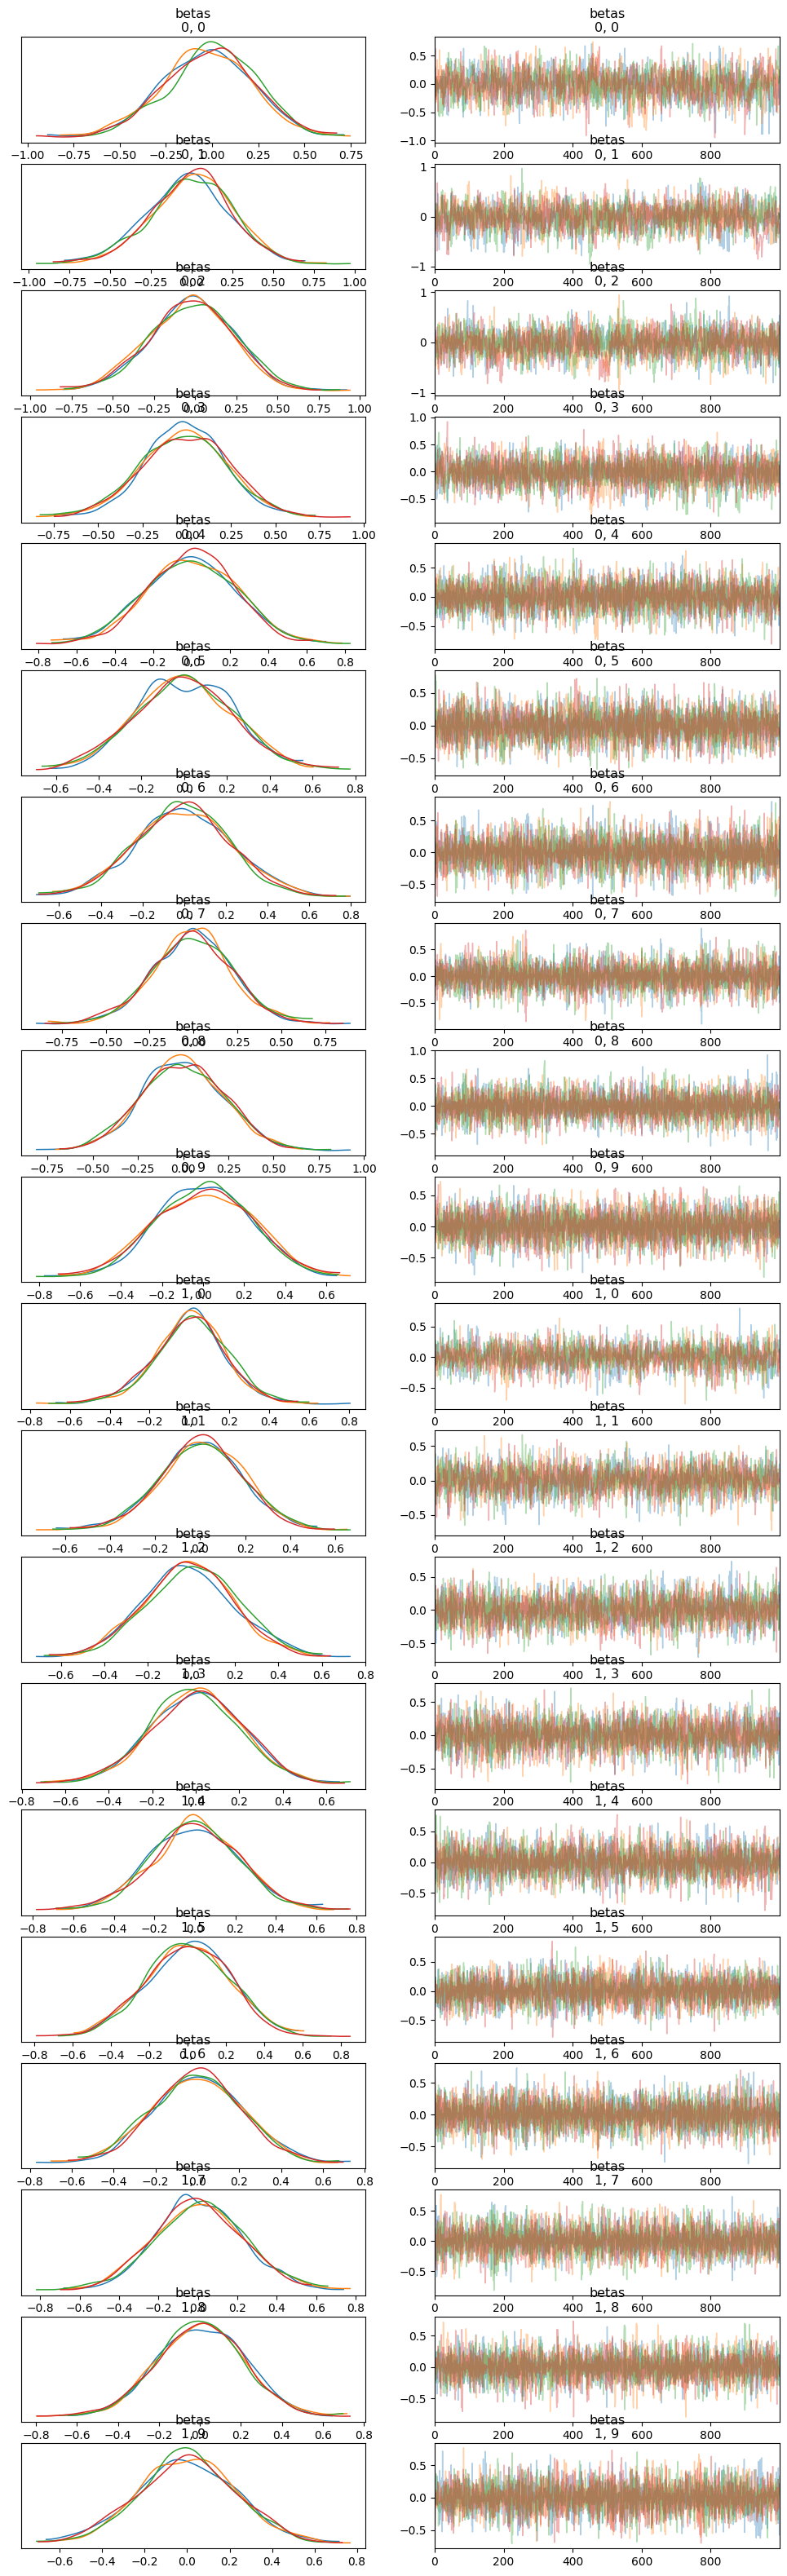

In [96]:
fit_az = az.from_cmdstanpy(fit)
az.plot_trace(fit, var_names=["betas"], compact=False)
plt.show()

In [99]:
clus =  np.array(fit_az.posterior.s.values[0, -1, :])
print('s')
print(clus)
print('true clusters')
print(true_clus_allocs)

# once we have sampling from the posterior we can for istance use binder loss for clustering 

s
[1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 8. 1. 1. 5. 1.]
true clusters
[0. 1. 1. 2. 1. 1. 1. 0. 0. 0. 1. 1. 0. 2. 2. 0. 1. 2. 1. 0.]


In [100]:
fit.summary()

Mean      MCSE     StdDev          5%         50%  \
lp__             -393.169000  1.070900  20.413100 -427.002000 -393.108000   
alpha               1.707060  0.026613   0.901722    0.534707    1.546590   
sigma2              0.405787  0.006174   0.137283    0.222832    0.384906   
tau2                9.594490  0.057373   3.285030    5.166820    9.108520   
rho                 0.326732  0.002169   0.140910    0.126481    0.307982   
...                      ...       ...        ...         ...         ...   
log_probs[20,6]   -18.105200  0.285503   9.358860  -35.311900  -15.651700   
log_probs[20,7]   -18.694800  0.280303   9.324370  -36.265700  -16.341500   
log_probs[20,8]   -19.711500  0.289039   9.792200  -38.988800  -16.990900   
log_probs[20,9]   -20.300500  0.306399   9.648860  -38.789100  -17.789500   
log_probs[20,10]  -19.989400  0.342601  10.188600  -38.873400  -17.499100   

                         95%     N_Eff   N_Eff/s     R_hat  
lp__             -359.713000   363.345  0.332955  1.006360  
alpha               3.379130  1148.020  1.052000  1.004870  
sigma2              0.659866   494.385  0.453035  1.004710  
tau2               15.783400  3278.390  3.004190  0.999891  
rho                 0.583784  4220.240  3.867260  1.000000  
...                      ...       ...       ...       ...  
log_probs[20,6]    -8.712730  1074.550  0.984673  1.001730  
log_probs[20,7]    -9.076470  1106.580  1.014030  1.002420  
log_probs[20,8]    -9.567610  1147.750  1.051750  1.001200  
log_probs[20,9]   -10.136700   991.690  0.908745  1.003460  
log_probs[20,10]   -9.198110   884.411  0.810439  1.004350  

[473 rows x 9 columns]

In [101]:
#Extimate pi[i,j] to compute Binder loss
#Likely not the most clever way to compute the matrix

n_chains=4
n_iteration_per_chain=1000
Binder_matrix= np.zeros((I,I))
for n in range(n_chains):
    for m in range(n_iteration_per_chain):
        for i in range(I):
            for j in range(I):
                if(i!=j and fit_az.posterior.s.values[n,m,i]==fit_az.posterior.s.values[n,m,j]):
                    Binder_matrix[i,j]+=1
                
Binder_matrix= Binder_matrix/(n_chains*n_iteration_per_chain)



In [102]:
#define Binder Loss

#Commented I added a penalty for a large number of clusters
#With penalty_n_clus=0 standard binder loss

def binder_function(binder_alloc):
    loss=0
    #penalty_n_clus=1
    #loss=penalty_n_clus*np.unique(binder_alloc).size
    
    for i in range(I):
        for j in range(I):
            
            if(binder_alloc[i]==binder_alloc[j]):
                    loss+=(1-Binder_matrix[i,j])**2
            
            else:
                loss+=(Binder_matrix[i,j])**2
            
    return loss

    

In [103]:
#Minimize Binder loss
# doesn't work with I big enough
#This solutions test every possibility and permutation
#it is likely to give a memory error

#import scipy
#max_n_clus=5
#ranges=[(0,max_n_clus-1)]*I
#scipy.optimize.brute(binder_function, ranges,  Ns=max_n_clus)

In [120]:
#Minimize Binder Loss evaluating the loss only 
#in the solutions found by stan model
#Not completly correct but should be a good doable approximation
n_chains=4
iteration_per_chain=1000
min_loss=10000
s_fixed=np.zeros(I)
for n in range(n_chains):
    for m in range(iteration_per_chain):
        loss=binder_function(fit_az.posterior.s.values[n,m])
        if(loss<min_loss):
            s_fixed=fit_az.posterior.s.values[n,m]

print('S_fixed')
print(s_fixed)

        
        

S_fixed
[3. 4. 1. 1. 3. 1. 0. 0. 0. 0. 4. 4. 2. 1. 2. 0. 0. 2. 5. 3.]


In [114]:
print('True clusters')
print(true_clus_allocs)

True clusters
[0. 1. 1. 2. 1. 1. 1. 0. 0. 0. 1. 1. 0. 2. 2. 0. 1. 2. 1. 0.]


In [121]:
# Fixed clustering s to study betas depending on clusters
beta_clus_stan = """
data
{
    int<lower=1> I; // number of areal locations
    int<lower=1> T; // number of time steps
    int<lower=1> P; // number of covariates
    int<lower=1> H; // number of possible clusters
    
    vector[I*T]     y; // output values
    matrix[I*T,P+1] X; // covariate matrix
    // syntax: y(i,t) = y[T*(i-1) + t]
    
    matrix[I,I] W_raw; // proximity matrix
      
    // hyperpar vector of regressors
    vector[P+1]     mu_0; 
    matrix[P+1,P+1] Sigma_0;
    
    // w_1
    vector[I] mu_w_1;
    
    // alpha
    real<lower=0> a_alpha;
    real<lower=0> b_alpha;
    
    // tau^2
    real<lower=0> a_tau2;
    real<lower=0> b_tau2;
    
    // sigma^2
    real<lower=0> a_sigma2;
    real<lower=0> b_sigma2;
    
    // rho
    real<lower=0> alpha_rho;
    real<lower=0> beta_rho;
    
    //xis
    real<lower=0> a_xi;
    real<lower=0> b_xi;
    
    int s[I];
}

transformed data
{
    vector[T] ones_T;
    for (t in 1:T)
        ones_T[t] = 1;
    
    matrix[T,T] eye_T;
    eye_T = diag_matrix(ones_T);
 
    vector[I] ones_I;
    for (i in 1:I)
        ones_I[i] = 1;
    
    matrix[I,I] eye_I;
    eye_I = diag_matrix(ones_I);
        
    matrix[I,I] W;
    W = diag_matrix(W_raw*ones_I) - W_raw;
    
    
}

parameters
{
    real<lower=0> sigma2;
    real<lower=0> tau2;
    real<lower=0,upper=1> rho;
    
    
    // autoregressive coefficients still to reparametrize
    vector<lower=0,upper=1>[I]    xis_constructors;
    
    // random effects
    matrix[T,I]                ws;
    
   //Betas depend on clusters
    matrix[P+1,H]              betas_clus; 
    
    
}


model
{
    
    sigma2 ~ inv_gamma(a_sigma2,b_sigma2);
    tau2   ~ inv_gamma(a_tau2,b_tau2);
    rho    ~ beta(alpha_rho,beta_rho);
    
    
    xis_constructors ~ beta(a_xi,b_xi);
    vector[I] xis;
    xis = 2 * xis_constructors - 1; 
    matrix[I,I] inv_Q;
    inv_Q = inverse_spd(rho*W + (1-rho)*eye_I);
    
    ws[1,1:I] ~ multi_normal(mu_w_1, tau2*inv_Q);
    
    for (t in 2:T)
        ws[t,1:I] ~ multi_normal(ws[t-1,1:I]*diag_matrix(xis), tau2*inv_Q);
    
    for(h in 1:H)
    {
        betas_clus[1:P+1,h] ~ multi_normal(mu_0, Sigma_0);
    }
    for (i in 1:I){
        int clus_i=s[i]+1;
        
        y[T*(i-1)+1:i*T] ~ multi_normal(X[T*(i-1)+1:i*T, 1:P+1]*betas_clus[1:P+1,clus_i] + ws[1:T,i], sigma2*eye_T);
    }    
}

"""

stan_file = "beta_clus.stan"

with open(stan_file, "w") as fp:
    fp.write(beta_clus_stan)
    
beta_clus = CmdStanModel(stan_file=stan_file)

11:12:33 - cmdstanpy - INFO - compiling stan file /home/anna-ubuntu/bayesian-project/beta_clus.stan to exe file /home/anna-ubuntu/bayesian-project/beta_clus
11:14:16 - cmdstanpy - INFO - compiled model executable: /home/anna-ubuntu/bayesian-project/beta_clus
11:14:16 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
11:14:16 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/anna-ubuntu/bayesian-project/beta_clus.hpp /home/anna-ubuntu/bayesian-project/beta_clus.stan
Warning in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 42, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/t

In [122]:
s= s_fixed.astype(int)

data_clus = {
    "I": I,
    "T": T,
    "P": P,
    "H": H,
    "y": y,
    "X": X,
    "W_raw": W_raw,
    "mu_0": mu_0,
    "Sigma_0": Sigma_0,
    "mu_w_1": mu_w_1,
    "a_alpha": 3,
    "b_alpha": 2,
    "a_tau2": 3,
    "b_tau2": 2,
    "a_sigma2": 3,
    "b_sigma2": 2,
    "alpha_rho": 5,
    "beta_rho": 1,
    "a_xi": 1,
    "b_xi": 1,
    "s":s
}


In [123]:
fit_clus = beta_clus.sample(data_clus
#                     , show_console = True
#                    , chains=4
#                     , adapt_delta=0.9
#                    , step_size = 1.5
#                    , max_treedepth = 100
                   )

11:15:25 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                        | 00:00 Status
chain 2 |                                                        | 00:00 Status

chain 3 |                                                        | 00:00 Status


chain 1 |██▌                                                     | 00:00 Status
chain 2 |██▌                                                     | 00:00 Status


chain 4 |██▌                                                     | 00:00 Status

chain 3 |██▌                                                     | 00:00 Status
chain 2 |██                     | 00:48 Iteration:    1 / 2000 [  0%]  (Warmup)

chain 1 |██                     | 01:22 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 4 |██                     | 01:25 Iteration:    1 / 2000 [  0%]  (Warmup)
chain 1 |███▏                   | 02:05 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███▏                   | 02:05 Iteration:  100


11:30:11 - cmdstanpy - INFO - CmdStan done processing.
11:30:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,5] = 2.3377e+08, but Covariance matrix[5,1] = 2.3377e+08 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = 7.88002e+17, but Covariance matrix[2,1] = 7.88002e+17 (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 101, column 4 to column 49)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan', line 113, column 8 to column 116)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in '/home/anna-ubuntu/bayesian-project/beta_clus.stan

/home/anna-ubuntu/.local/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


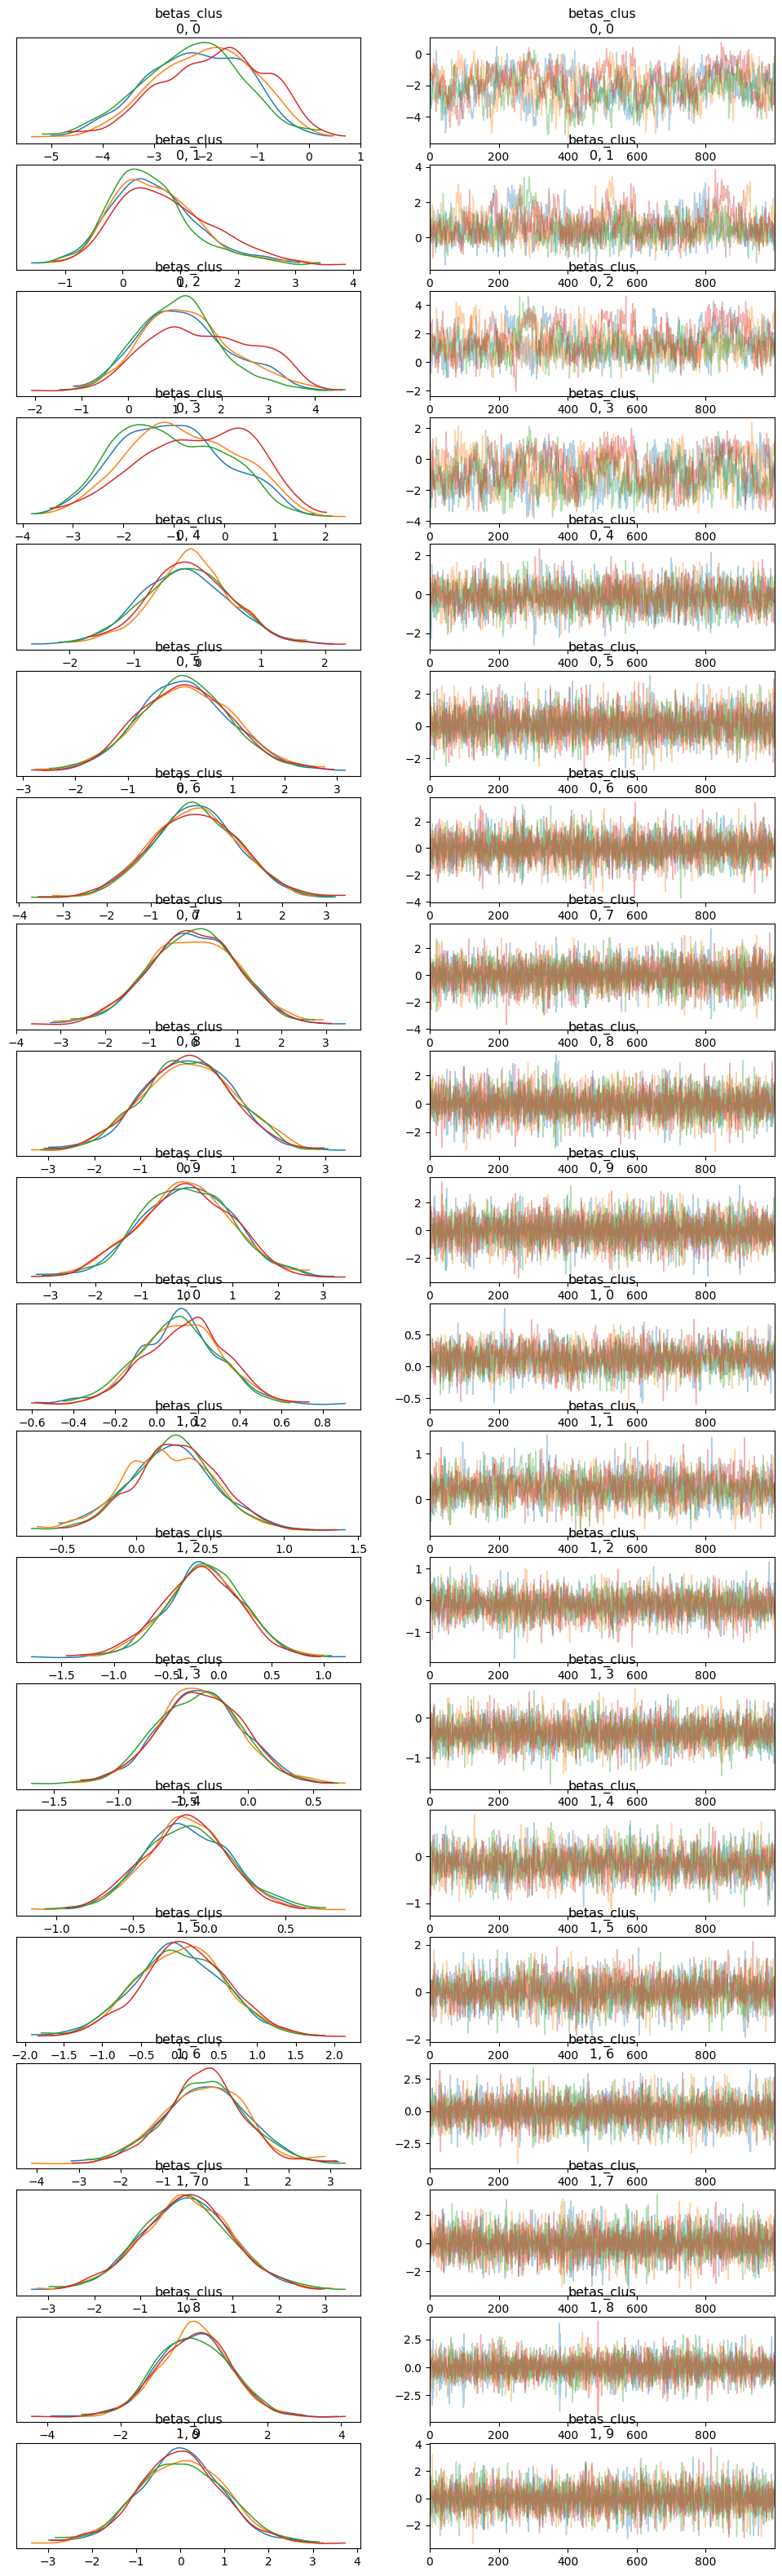

In [124]:
#betas[p,h] plot the betas specific to the clusters
fit_clus_az = az.from_cmdstanpy(fit_clus)
az.plot_trace(fit_clus, var_names=["betas_clus"], compact=False)
plt.show()


array([[<AxesSubplot: title={'center': 'betas_clus\n0, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 1'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 3'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 5'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 6'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 7'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n0, 8'}>,
        <AxesSubplot: title={'center': 'betas_clus\n0, 9'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 0'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 1'}>],
       [<AxesSubplot: title={'center': 'betas_clus\n1, 2'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 3'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 4'}>,
        <AxesSubplot: title={'center': 'betas_clus\n1, 5'}>],
       [<AxesSubplot

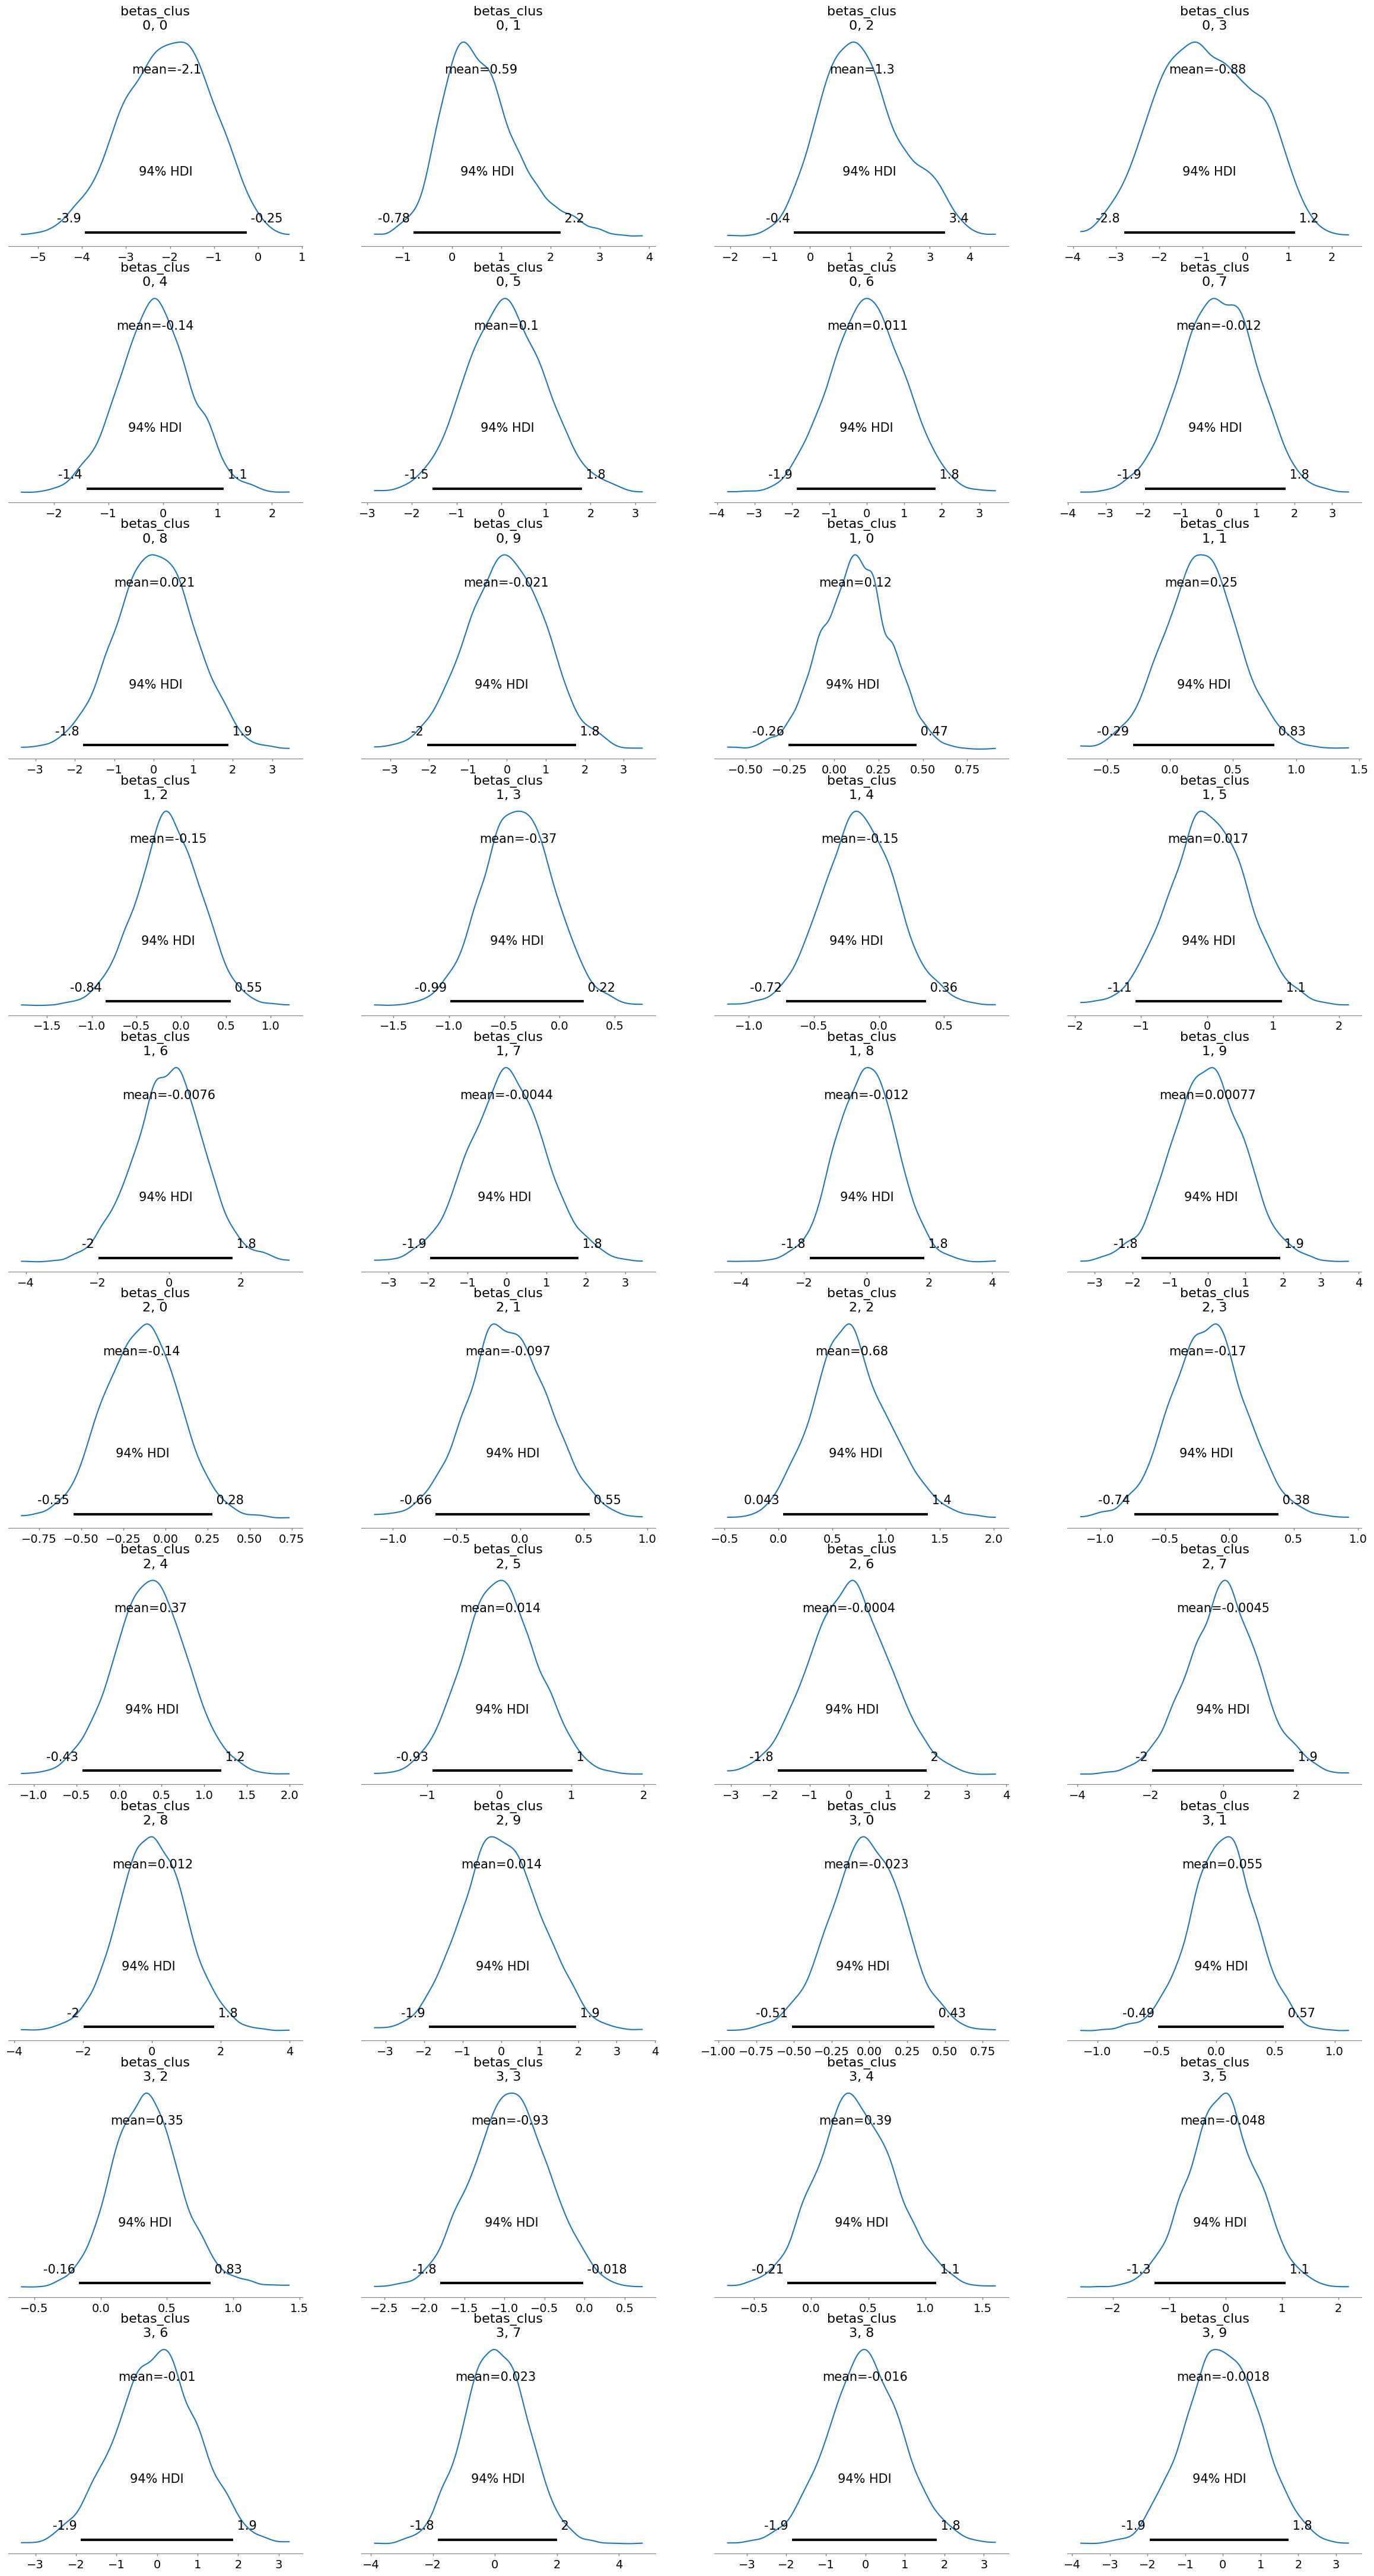

In [125]:
az.plot_posterior(fit_clus_az, var_names='betas_clus')

<AxesSubplot: >

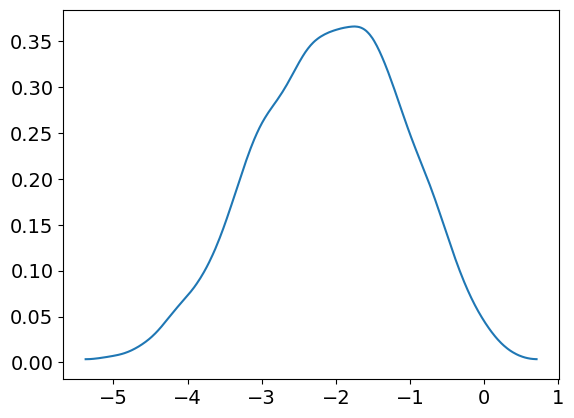

In [127]:
h=0   #plot the posterior of betas seen in cluster h

az.plot_dist(values=fit_clus_az.posterior.betas_clus.values[0:,0:,0,h])